In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification

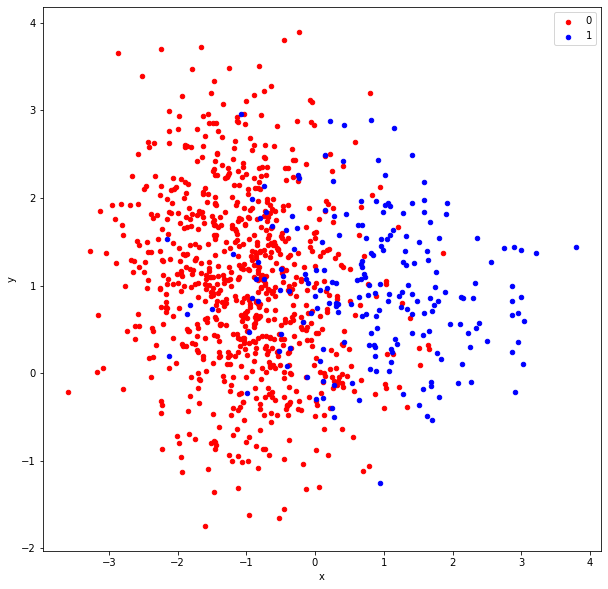

In [31]:
#Generate synthetic dataset
X, y = make_classification(n_samples = 1000,
                           n_features = 2,
                           n_redundant = 0,
                           n_clusters_per_class = 1,
                           weights = [0.80],
                           random_state = 56)

df = pd.concat([pd.DataFrame(X), pd.Series(y)], axis = 1)
df.columns = ['x', 'y', 'label']

fig, ax = plt.subplots(figsize = (10,10))
grouped = df.groupby('label')
colors = {0:'red', 1:'blue'}
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
plt.show()

In [32]:
class RBO:
    
    def __init__(self, dataset, target_variable, step_size, n_iters, gamma, criteria):
        assert criteria in ['balance', 'maximize', 'minimize']
        
        self.dataset = dataset
        self.target_variable = target_variable
        self.step_size = step_size
        self.n_iters = n_iters
        self.eps = 1/gamma
        self.criteria = criteria
        
    
    def get_class_data(self):
        
        classes = self.dataset[self.target_variable].unique()
        class_weights = self.dataset[self.target_variable].value_counts() / len(self.dataset)
        self.min_class = np.argmin(class_weights)
        self.max_class = np.argmax(class_weights)
        self.k = self.dataset[self.dataset[self.target_variable] == self.min_class].iloc[:,:-1]
        self.K = self.dataset[self.dataset[self.target_variable] == self.max_class].iloc[:,:-1]
    
    def rbf(self, x, y):

        distance = np.sum(np.abs(x - y))
        rbf = np.exp(-(distance * self.eps) ** 2)
        
        return rbf
    
    def score(self, point):
        
        mutual_density_score = 0
        
        for i in self.K.index:
            rbf_ = self.rbf(point.values, self.K.loc[i].values)
            mutual_density_score += rbf_
        
        for i in self.k.index:
            rbf_ = self.rbf(point.values, self.k.loc[i].values)
            mutual_density_score -= rbf_
        
        return mutual_density_score
            
    
    def generate_samples(self):
        
        min_scores = {}
        for i in self.k.index:
            min_scores[i] = self.score(self.k.loc[i])
        
        samples = pd.DataFrame(columns = self.k.columns)
        while len(samples) + len(self.k) < len(self.K):
            idx = np.random.choice(self.k.index)
            point = self.k.loc[idx].copy()
            score = min_scores[idx]
            
            preserve = False
            for i in range(self.n_iters):
                translated = point.copy()
                direction = np.random.choice(list(point.index))
                sign = np.random.choice([-1,1])
                translated[direction] = translated[direction] + (sign * self.step_size)
                translated_score = self.score(translated)
                
                if self.criteria == 'balance' and np.abs(translated_score) < np.abs(score):
                    preserve = True
                    point = translated
                    score = translated_score
                
                elif self.criteria == 'maximize' and translated_score > score:
                    preserve = True
                    point = translated
                    score = translated_score
                
                elif self.criteria == 'minimize' and translated_score < score:
                    preserve = True
                    point = translated
                    score = translated_score
                
            if preserve == True:
                samples = samples.append(point, ignore_index = True)
            
        samples[self.target_variable] = self.min_class
        df_upsampled = self.dataset.append(samples, ignore_index = True)
        
        return df_upsampled 
    
    def __call__(self):
        
        self.get_class_data()
        df_upsampled = self.generate_samples()
        
        return df_upsampled

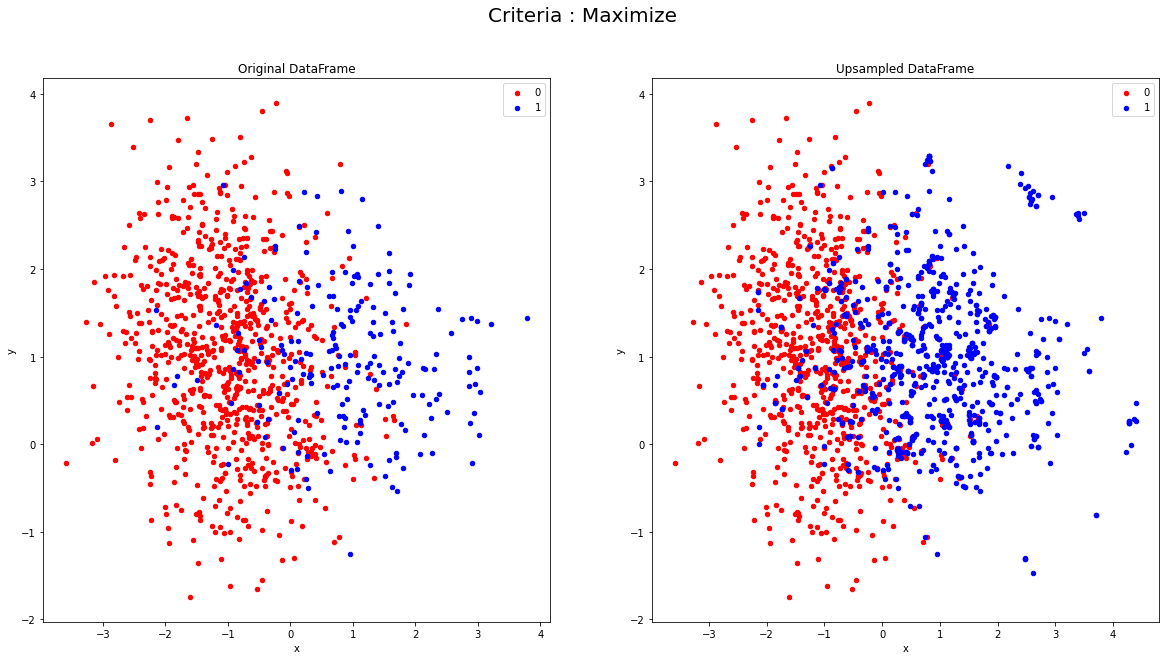

In [33]:
rbo = RBO(dataset = df, target_variable = 'label', step_size = 0.2, n_iters = 50, gamma = 0.05,
         criteria = 'maximize')
df_upsampled = rbo()

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (20,10))
grouped = df_upsampled.groupby('label')
colors = {0:'red', 1:'blue'}
for key, group in grouped:
    group.plot(ax=ax2, kind='scatter', x='x', y='y', label=key, color=colors[key])
    ax2.set_title('Upsampled DataFrame')

grouped = df.groupby('label')
colors = {0:'red', 1:'blue'}
for key, group in grouped:
    group.plot(ax=ax1, kind='scatter', x='x', y='y', label=key, color=colors[key])
    ax1.set_title('Original DataFrame')
fig.suptitle('Criteria : Maximize', fontsize = 20)

plt.show()    

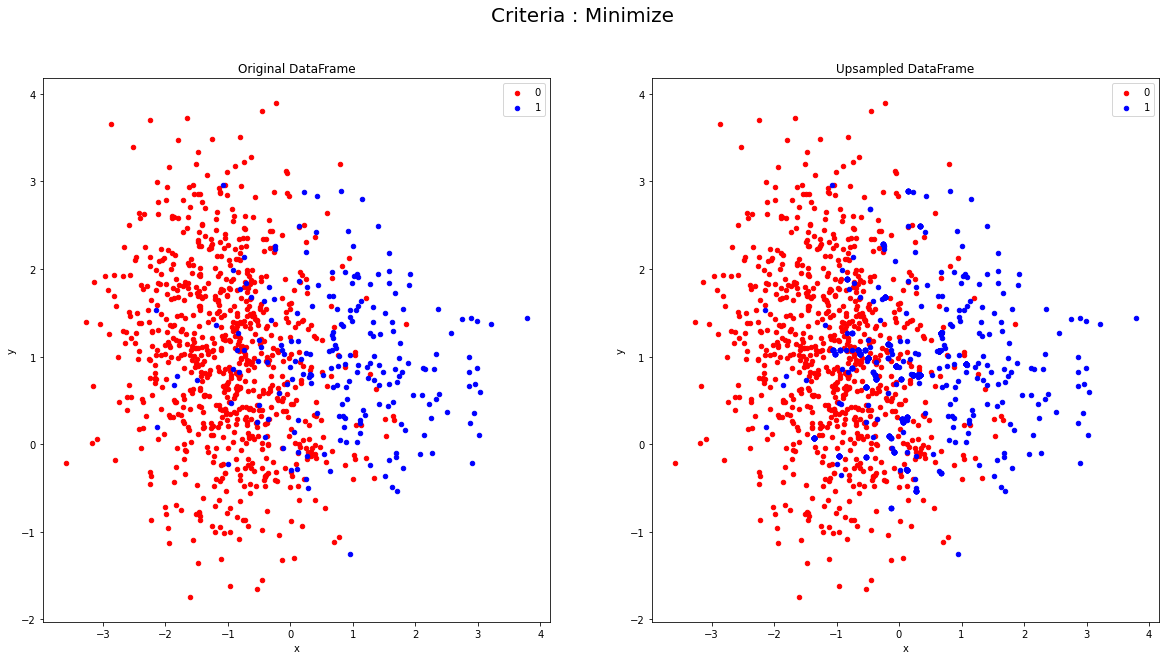

In [34]:
rbo = RBO(dataset = df, target_variable = 'label', step_size = 0.2, n_iters = 50, gamma = 0.05,
         criteria = 'minimize')
df_upsampled = rbo()

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (20,10))
grouped = df_upsampled.groupby('label')
colors = {0:'red', 1:'blue'}
for key, group in grouped:
    group.plot(ax=ax2, kind='scatter', x='x', y='y', label=key, color=colors[key])
    ax2.set_title('Upsampled DataFrame')

grouped = df.groupby('label')
colors = {0:'red', 1:'blue'}
for key, group in grouped:
    group.plot(ax=ax1, kind='scatter', x='x', y='y', label=key, color=colors[key])
    ax1.set_title('Original DataFrame')
fig.suptitle('Criteria : Minimize', fontsize = 20)

plt.show()   

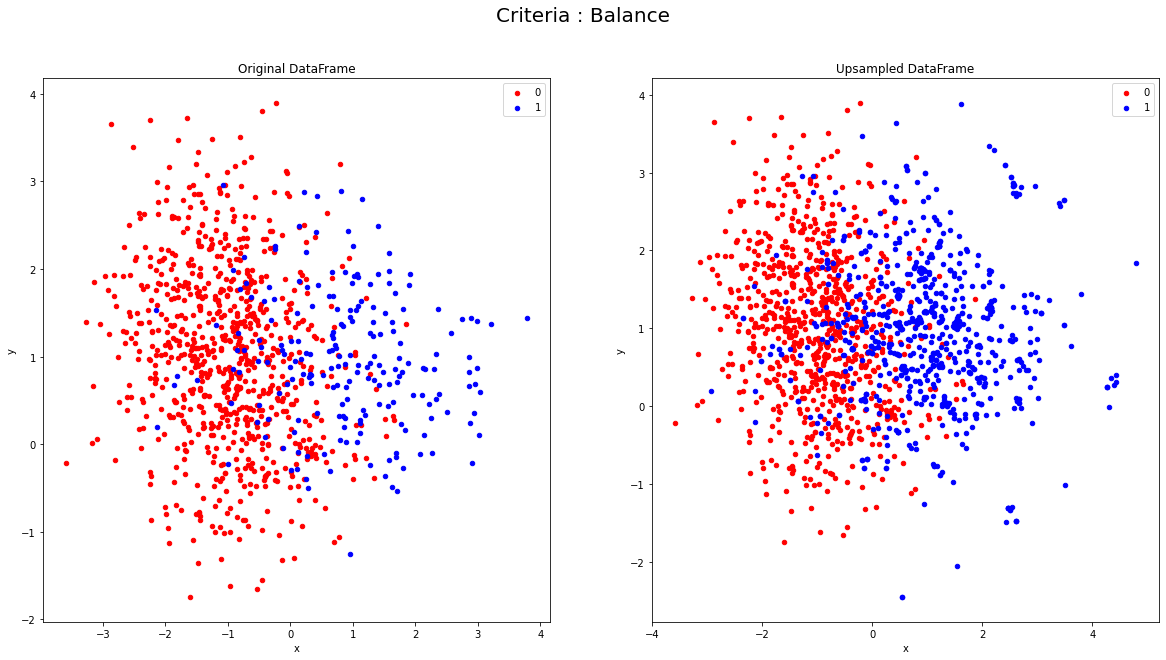

In [35]:
rbo = RBO(dataset = df, target_variable = 'label', step_size = 0.2, n_iters = 50, gamma = 0.05,
         criteria = 'balance')
df_upsampled = rbo()

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (20,10))
grouped = df_upsampled.groupby('label')
colors = {0:'red', 1:'blue'}
for key, group in grouped:
    group.plot(ax=ax2, kind='scatter', x='x', y='y', label=key, color=colors[key])
    ax2.set_title('Upsampled DataFrame')

grouped = df.groupby('label')
colors = {0:'red', 1:'blue'}
for key, group in grouped:
    group.plot(ax=ax1, kind='scatter', x='x', y='y', label=key, color=colors[key])
    ax1.set_title('Original DataFrame')
fig.suptitle('Criteria : Balance', fontsize = 20)

plt.show()   